# Run Watson Classifiers in Time-Period Configuration

###### Author: Alberto Nieto
###### Organization: Esri
###### Date: June, 2017

![Machine Learning Integration](../img/integration2.jpg)

# Pseudocode

Goal: To run classification on a specified time period using snapshots provided by Cobb County, storing the outputs on a time-enabled hosted service. 

Procedure:

1. Routine Setup

    1a. Authentication
        - IBM Watson
        - ArcGIS Online
    
    1b. Retrieve Models
    
    1c. Retrieve input images location
    
    1d. Retrieve target hosted service
    
2. Set Helper Functions

    2a. Get time-period snapshots
    
    2b. Classify Image
    
    2c. Update hosted service feature
    
    2d. Add hosted service feature
     
3. Iteration

    For each camera:
    
        3a. Get time-period snapshots

        3b. For each snapshot:
        
            3ba. Classify image

            3bb. Update/Add feature to service

# 1. Routine Setup

Imported modules

In [1]:
import os
from watson_developer_cloud import VisualRecognitionV3
import arcgis
import pandas as pd
from copy import deepcopy
import requests
from bs4 import BeautifulSoup
import json
from IPython.display import Image, display
from IPython.core.display import HTML 
import scipy.misc
from datetime import datetime, timedelta
import time
import re

workspace

In [2]:
workspace_dir = os.getcwd()+"\\Temp"

## IBM Watson Authentication

In [3]:
visual_recognition = VisualRecognitionV3(
    '2018-03-19',
    iam_api_key=os.environ['BLUEMIX_API_KEY'])

## ArcGIS Authentication

In [4]:
gis = arcgis.gis.GIS(os.environ['ESRIFEDERAL_URL'], username="Anieto_esrifederal")

Enter password: ········


## 1b. Retrieve Models

In [5]:
models_dict = visual_recognition.list_classifiers(verbose=True); models_dict

{'classifiers': [{'classes': [{'class': 'low'},
    {'class': 'medium'},
    {'class': 'high'}],
   'classifier_id': 'Esri_Classification_CobbCounty_371717976',
   'core_ml_enabled': True,
   'created': '2018-06-26T15:08:09.890Z',
   'name': 'Esri_Classification_CobbCounty_Cam130',
   'owner': '52d3c878-5f0a-44c6-b191-358d19be7bc5',
   'status': 'ready',
   'updated': '2018-06-26T15:08:09.890Z'},
  {'classes': [{'class': 'low'}, {'class': 'medium'}, {'class': 'high'}],
   'classifier_id': 'Esri_Classification_CobbCounty_1442278062',
   'core_ml_enabled': True,
   'created': '2018-06-29T16:49:37.354Z',
   'name': 'Esri_Classification_CobbCounty_Cam130_v2',
   'owner': '52d3c878-5f0a-44c6-b191-358d19be7bc5',
   'status': 'ready',
   'updated': '2018-06-29T16:49:37.354Z'},
  {'classes': [{'class': 'low'}, {'class': 'medium'}, {'class': 'high'}],
   'classifier_id': 'Esri_Classification_CobbCounty_1492191311',
   'core_ml_enabled': True,
   'created': '2018-06-29T16:49:13.296Z',
   'name':

In [6]:
models_df = pd.DataFrame.from_dict(models_dict['classifiers']); models_df

,classes,classifier_id,core_ml_enabled,created,name,owner,status,updated
0,"[{'class': 'low'}, {'class': 'medium'}, {'clas...",Esri_Classification_CobbCounty_371717976,True,2018-06-26T15:08:09.890Z,Esri_Classification_CobbCounty_Cam130,52d3c878-5f0a-44c6-b191-358d19be7bc5,ready,2018-06-26T15:08:09.890Z
1,"[{'class': 'low'}, {'class': 'medium'}, {'clas...",Esri_Classification_CobbCounty_1442278062,True,2018-06-29T16:49:37.354Z,Esri_Classification_CobbCounty_Cam130_v2,52d3c878-5f0a-44c6-b191-358d19be7bc5,ready,2018-06-29T16:49:37.354Z
2,"[{'class': 'low'}, {'class': 'medium'}, {'clas...",Esri_Classification_CobbCounty_1492191311,True,2018-06-29T16:49:13.296Z,Esri_Classification_CobbCounty_Cam129_v2,52d3c878-5f0a-44c6-b191-358d19be7bc5,ready,2018-06-29T16:49:13.296Z
3,"[{'class': 'low'}, {'class': 'medium'}, {'clas...",Esri_Classification_CobbCounty_1256542849,True,2018-06-26T15:00:48.899Z,Esri_Classification_CobbCounty_Cam128,52d3c878-5f0a-44c6-b191-358d19be7bc5,ready,2018-06-26T15:00:48.899Z
4,"[{'class': 'low'}, {'class': 'medium'}, {'clas...",Esri_Classification_CobbCounty_1653483892,True,2018-06-29T16:48:56.598Z,Esri_Classification_CobbCounty_Cam128_v2,52d3c878-5f0a-44c6-b191-358d19be7bc5,ready,2018-06-29T16:48:56.598Z
5,"[{'class': 'low'}, {'class': 'medium'}, {'clas...",Esri_Classification_CobbCounty_361684145,True,2018-06-26T15:06:56.039Z,Esri_Classification_CobbCounty_Cam129,52d3c878-5f0a-44c6-b191-358d19be7bc5,ready,2018-06-26T15:06:56.039Z


In [7]:
model_128_name = 'Esri_Classification_CobbCounty_Cam128_v2'
model_129_name = 'Esri_Classification_CobbCounty_Cam129_v2'
model_130_name = 'Esri_Classification_CobbCounty_Cam130_v2'

In [8]:
model_128_id = models_df.loc[models_df['name'] == model_128_name, 'classifier_id'].values[0]
model_129_id = models_df.loc[models_df['name'] == model_129_name, 'classifier_id'].values[0]
model_130_id = models_df.loc[models_df['name'] == model_130_name, 'classifier_id'].values[0]

In [9]:
cameraid_model_dict = {
    "128": model_128_id,
    "129": model_129_id,
    "130": model_130_id
}

## 1c. Retrieve input images location

In [10]:
images_url = r"https://www.cobbgis.org/openimage/bravescam"
cams = ["128", "129", "130"]
cam_urls = ["{0}/Cam{1}".format(images_url, cam) for cam in cams]; cam_urls

['https://www.cobbgis.org/openimage/bravescam/Cam128',
 'https://www.cobbgis.org/openimage/bravescam/Cam129',
 'https://www.cobbgis.org/openimage/bravescam/Cam130']

## 1d. Retrieve target hosted service

<Item title:"SunTrust_PedestrianFlows_EventSimulation_F" type:Feature Layer Collection owner:Anieto_esrifederal>
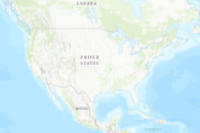

In [11]:
# target_service_name = "SunTrustPark_TrafficCameras_T01"
target_service_name = "SunTrust_PedestrianFlows_EventSimulation_F"
# Set schema of target point service
label_attribute_name = 'pedestrian_density'
camera_id_attribute_name = 'camera_id'
source_image_attribute_name = 'source_image'
object_point_srvc = gis.content.search(target_service_name, item_type="Feature Layer")[0]
object_point_srvc

# 2. Set Helper Functions

## 2a. Get Datetime Object from CobbURL

In [12]:
def get_datetime_from_cobburl(cobburl):
    split = cobburl.split("-")
    yy = split[0][-2:]
    mm = split[1]
    dd = split[2].split("_")[0]
    hh = split[2].split("_")[1]
    minute = split[3]
    ss = split[4]
    return datetime.strptime('{0}{1}{2}{3}{4}{5}'.format(yy, mm, dd, hh, minute, ss), '%y%m%d%H%M%S')

In [13]:
# Test function
testurl = r"https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-27_21-00-09-03.jpg"
get_datetime_from_cobburl(testurl)

datetime.datetime(2018, 6, 27, 21, 0, 9)

## 2a. Get Time-Period Snapshots

In [14]:
def get_full_snapshot_urls_df(images_webpage_url):
    # Use requests module to retrieve the page
    page = requests.get(images_webpage_url)
    # Use beautifulsoup module to scrape content
    soup = BeautifulSoup(page.content)
    # Build list of links
    links = []
    for link in soup.findAll('a'):
        if link.get('href') != "/openimage/bravescam/":
            links.append(link.get('href'))
    urls_df = pd.DataFrame(data=links, columns=["url"])
    urls_df['datetime'] = urls_df.apply(lambda row: get_datetime_from_cobburl(row['url']), axis=1)
    urls_df['time'] = urls_df.apply(lambda row: get_datetime_from_cobburl(row['url']), axis=1)
    urls_df = urls_df.set_index(['datetime'])
    return urls_df

In [15]:
# Test function
test_df = get_full_snapshot_urls_df(cam_urls[0]); test_df

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\ProgramData\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


,url,time
datetime,,
2018-06-21 14:34:09,/openimage/bravescam/Cam128/Cam_12818-06-21_14...,2018-06-21 14:34:09
2018-06-21 14:34:19,/openimage/bravescam/Cam128/Cam_12818-06-21_14...,2018-06-21 14:34:19
2018-06-21 14:34:29,/openimage/bravescam/Cam128/Cam_12818-06-21_14...,2018-06-21 14:34:29
2018-06-21 14:34:39,/openimage/bravescam/Cam128/Cam_12818-06-21_14...,2018-06-21 14:34:39
2018-06-21 14:34:49,/openimage/bravescam/Cam128/Cam_12818-06-21_14...,2018-06-21 14:34:49
2018-06-21 14:34:59,/openimage/bravescam/Cam128/Cam_12818-06-21_14...,2018-06-21 14:34:59
2018-06-21 14:35:09,/openimage/bravescam/Cam128/Cam_12818-06-21_14...,2018-06-21 14:35:09
2018-06-21 14:35:19,/openimage/bravescam/Cam128/Cam_12818-06-21_14...,2018-06-21 14:35:19
2018-06-21 14:35:29,/openimage/bravescam/Cam128/Cam_12818-06-21_14...,2018-06-21 14:35:29


In [16]:
def get_time_period_snapshot_urls_df(urls_df, time_period_start, time_period_end):
    
    """
    Retrieve a list of image urls within a specified time period from the Cobb County SunTrust Park images repository
    :param images_webpage_url: String - Full path to HTTPS url for SunTrust Park images repository
    
    :return: List - List of snapshot urls for the specified time period
    """ 
    
    # Convert the input time period start and end into datetime objects
    start_dto = datetime.strptime(time_period_start, '%y-%m-%d_%H-%M-%S')
    end_dto = datetime.strptime(time_period_end, '%y-%m-%d_%H-%M-%S')
    
    # Get urls_df rows within datetime bounds
    urls_df = urls_df[start_dto:end_dto]
    return urls_df

In [ ]:
# Test function
time_period_start = "18-06-27_21-00-00"
time_period_end = "18-06-27_22-00-00"
period_df = get_time_period_snapshot_urls_df(test_df, time_period_start, time_period_end); period_df

In [17]:
def download_single_snapshot(snapshot_url, datetime, workspace):
    
    """
    Retrieve the latest image from the Cobb County SunTrust Park images repository, store locally, and return path
    :param images_webpage_url: String - Full path to HTTPS url for SunTrust Park images repository
    :param workspace: String - Full path to directory where image can be stored
    :return: String - Full directory path to locally stored image
    """ 
       
    # Retrieve latest image
    full_image_url = "{0}{1}".format("https://www.cobbgis.org", snapshot_url)
    print(full_image_url)
    # Write image locally to workspace
    image_path = "{0}\\temp_latest_image.jpg".format(workspace)
    with open(image_path, 'wb') as handle:
        response = requests.get(full_image_url, stream=True)
        if not response.ok:
            print(response)
        for block in response.iter_content(1024):
            if not block:
                break
            handle.write(block)
    if os.path.isfile(image_path):           
        return image_path, full_image_url, datetime
    else:
        return None

In [ ]:
# Test function
period_df.iloc[0]['url']
period_df.iloc[0]['time']
test_image, test_image_url, test_datetime = download_single_snapshot(period_df.iloc[0]['url'], period_df.iloc[0]['time'], workspace_dir)

## 2b. Classify Image

In [18]:
def classify_image(image, classifier_id, threshold_val='0.15', display_image=False):
    """
    Pass a locally stored image to a Watson classifier and return the classification results
    :param image: String - Full path to locally stored image
    :param classifier_id: String - Classifier ID
    :param threshold_val: String - Numeric value in string format that establishes which classes are returned
    :return: JSON - classes determined by Watson classifier
    """ 
    if display_image:
        display(Image(image))
    with open(image, 'rb') as images_file:
        classes = visual_recognition.classify(
            images_file,
            threshold=threshold_val,
            classifier_ids=classifier_id)
        output_class = classes['images'][0]['classifiers'][0]['classes'][0]['class']
    return output_class

In [ ]:
# Test function
Image(test_image)
test_label = classify_image(test_image, model_128_id, display_image=True)
test_label

## 2c. Update hosted service feature

In [19]:
def update_hosted_service_feature(source_label, source_camera_id, source_image_url, source_image_localpath, source_datetime,
                                  target_service, target_label_field, target_camera_id_field, target_source_image_field,
                                  overwrite_attachment=True, layer_index=0):
    
    # Convert our existing service into a pandas dataframe
    target_lyr = target_service.layers[layer_index]   
    target_fset = target_lyr.query(where="""camera_id = '"""+source_camera_id+"""'""", return_geometry=False)  
    all_features = target_fset.features
    original_feature = all_features[0]
    feature_to_be_updated = deepcopy(original_feature)
    
    features_for_update = []
    feature_to_be_updated.attributes[target_label_field] = source_label.capitalize()  # Use capitalize due to domain
    feature_to_be_updated.attributes[target_source_image_field] = source_image_url
    feature_to_be_updated.attributes['classification_time'] = source_datetime
    
    # Store attribute updates and send edit request
    features_for_update.append(feature_to_be_updated)
    target_lyr.edit_features(updates=features_for_update) 
    
    # Perform attachment of detected image
    obj_id = feature_to_be_updated.attributes['OBJECTID']
    
    if overwrite_attachment:
        for attachment in target_lyr.attachments.get_list(obj_id):
            target_lyr.attachments.delete(obj_id, attachment['id'])

    target_lyr.attachments.add(obj_id, source_image_localpath)

In [ ]:
# Test Function
Image(test_image)
test_label = classify_image(test_image, model_128_id, display_image=True)
update_hosted_service_feature(test_label, "128", test_image_url, test_image, test_datetime, object_point_srvc, "pedestrian_density", "camera_id", "source_image")

## 2d. Add hosted service feature

In [20]:
# TODO
def add_hosted_service_feature(source_label, source_camera_id, source_image_url, source_image_localpath, source_datetime,
                               target_service, target_label_field, target_camera_id_field, target_source_image_field,
                               overwrite_attachment=True, layer_index=0):
    
    # Convert our existing service into a pandas dataframe
    target_lyr = target_service.layers[layer_index]   
    target_fset = target_lyr.query(where="""camera_id = '"""+source_camera_id+"""'""", return_geometry=True)  
    all_features = target_fset.features
    original_feature = all_features[0]
    
    features_to_be_added = []
    new_feature = deepcopy(original_feature)
    new_feature.attributes[target_label_field] = source_label.capitalize()  # Use capitalize due to domain
    new_feature.attributes[target_source_image_field] = source_image_url
    recording_id = "Cam{0}_{1}".format(str(source_camera_id), str(datetime.now().strftime("%m%d%y_%H%M%S")))
    new_feature.attributes['recording_id'] = recording_id
    new_feature.attributes['classification_time'] = source_datetime
    
    #add this to the list of features to be updated
    features_to_be_added.append(new_feature)
    target_lyr.edit_features(adds = features_to_be_added) 
    
    # Add attachments to new features
    try:
        new_rec_fset = target_lyr.query(where="""recording_id = '"""+recording_id+"""'""", return_geometry=False)  
        new_feature = new_rec_fset.features[0]
        obj_id = new_feature.attributes['OBJECTID']
        target_lyr.attachments.add(obj_id, source_image_localpath)
    except Exception as e:
        print("\tAttachment exception encountered. Bypassing attachment.")

In [ ]:
# Test Function
Image(test_image)
test_label = classify_image(test_image, model_128_id, display_image=True)
add_hosted_service_feature(test_label, "128", test_image_url, test_image, test_datetime, object_point_srvc, "pedestrian_density", "camera_id", "source_image")

# 2e. Iteration Helper (i.e. main)

In [21]:
def classify_for_time_period(camera_urls_list, time_start, time_end,
                                 images_webpage_url, workspace,
                                 camera_to_model_dict,
                                 target_service, target_label_field, target_camera_id_field, target_source_image_field,    
                                 threshold_val='0.15', display_image=False, overwrite_attachment=True, layer_index=0, 
                                 edit="update", verbose=False):
    
    
    
    print("\n>>>>Performing Classification sweep for specified time period<<<<")

    # Iterate on each camera
    for cam_url in camera_urls_list:

        camera_id = cam_url[-3:]

        print("\n\nClassifying current pedestrian activity for camera {0}...".format(str(camera_id)))
        classifier_id = cameraid_model_dict[camera_id]
        if verbose:
            print("\tApplying model {0}...".format(classifier_id))
        
        if verbose:
            print("\tRetrieving full dataframe of snapshots...")
        full_snapshots_df = get_full_snapshot_urls_df(cam_url)
        
        if verbose:
            print("\tRetrieving time period snapshots df subset...")
        time_period_df = get_time_period_snapshot_urls_df(full_snapshots_df, time_start, time_end)
          
        if verbose:
            print("\tIterating on snapshots for time period for camera...")
        
        for index, row in time_period_df.iterrows():
            if verbose:
                print("\n\t\tDownloading snapshot for {0}...".format(str(row['time'])))           
            image, image_url, datetime = download_single_snapshot(row['url'], row['time'], workspace)
          
        
            if verbose:
                print("\t\tClassifying snapshot...")
            try:
                label = classify_image(image, classifier_id, display_image=False)
            except Exception as e:
                print("\t\tWatson exception encountered. Trying again...")
                time.sleep(2)
                try:
                    label = classify_image(image, classifier_id, display_image=False)
                except Exception as e:
                    print("\t\tWatson exception encountered again. Bypassing observation.")
                    label = "NA"

            if edit == "update":
                if verbose:
                    print("\t\tUpdating feature...")
                try:
                    update_hosted_service_feature(label, camera_id, image_url, image, datetime, object_point_srvc, "pedestrian_density", "camera_id", "source_image")
                except Exception as e:
                    print("\t\tFeature update exception encountered. Bypassing observation.")              
            elif edit == "add":
                if verbose:
                    print("\t\tAdding feature...")
                try:
                    add_hosted_service_feature(label, camera_id, image_url, image, datetime, object_point_srvc, "pedestrian_density", "camera_id", "source_image")
                except Exception as e:
                    print("\t\tFeature add exception encountered. Bypassing observation.")

In [ ]:
# Test main function
camera_urls_list = cam_urls
time_period_start = "18-06-27_21-00-00"
time_period_end = "18-06-27_21-15-00"

images_webpage_url = images_url
workspace = workspace_dir
camera_to_model_dict = cameraid_model_dict

target_service = object_point_srvc
target_label_field = label_attribute_name
target_camera_id_field = camera_id_attribute_name
target_source_image_field = source_image_attribute_name

classify_for_time_period(camera_urls_list, time_period_start, time_period_end,
                         images_webpage_url, workspace,
                         camera_to_model_dict,
                         target_service, target_label_field, target_camera_id_field, target_source_image_field,    
                         threshold_val='0.15', display_image=False, overwrite_attachment=True, layer_index=0, 
                         edit="add", verbose=True)

# 3. Time-Period Classification

## Enter Time Period in format YY-MM-DD_hh-mm-ss

In [22]:
time_period_start = "18-06-24_16-00-00"
time_period_end = "18-06-24_17-00-00"

In [23]:
# Test main function
camera_urls_list = cam_urls

images_webpage_url = images_url
workspace = workspace_dir
camera_to_model_dict = cameraid_model_dict

target_service = object_point_srvc
target_label_field = label_attribute_name
target_camera_id_field = camera_id_attribute_name
target_source_image_field = source_image_attribute_name

classify_for_time_period(camera_urls_list, time_period_start, time_period_end,
                         images_webpage_url, workspace,
                         camera_to_model_dict,
                         target_service, target_label_field, target_camera_id_field, target_source_image_field,    
                         threshold_val='0.15', display_image=False, overwrite_attachment=True, layer_index=0, 
                         edit="add", verbose=True)


>>>>Performing Classification sweep for specified time period<<<<


Classifying current pedestrian activity for camera 128...
	Applying model Esri_Classification_CobbCounty_1653483892...
	Retrieving full dataframe of snapshots...


C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\ProgramData\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


	Retrieving time period snapshots df subset...
	Iterating on snapshots for time period for camera...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-00-09-08.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-00-19-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-00-29-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-00-39-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-00-49-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-00-59-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-01-09-05.jpg
		Classifying snapshot...
		Adding 


https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-07-39-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-07-49-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-07-59-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-08-09-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-08-19-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-08-29-08.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-08-39-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-08-49-05.jpg
		Clas

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-15-19-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-15-29-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-15-39-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-15-49-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-15-59-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-16-09-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-16-19-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam


https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-22-49-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-22-59-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-23-09-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-23-19-02.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-23-29-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-23-39-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-23-49-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-23-59-05.jpg
		Clas

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-30-29-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-30-39-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-30-49-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-30-59-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-31-09-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-31-19-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-31-29-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-38-09-05.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-38-19-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-38-29-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-38-39-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-38-49-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-38-59-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-39-09-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-45-49-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-45-59-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-46-09-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-46-19-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-46-29-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-46-39-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-46-49-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam


https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-53-19-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-53-29-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-53-39-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-53-49-09.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-53-59-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-54-09-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-54-19-06.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam128/Cam_12818-06-24_16-54-29-06.jpg
		Clas

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-00-49-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-00-59-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-01-09-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-01-19-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-01-29-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-01-39-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-01-49-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-08-29-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-08-39-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-08-49-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-08-59-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-09-09-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-09-19-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-09-29-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam


https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-15-59-59.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-16-09-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-16-19-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-16-29-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-16-39-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-16-49-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-16-59-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-17-09-63.jpg
		Clas

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-23-39-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-23-49-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-23-59-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-24-09-60.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-24-19-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-24-29-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-24-39-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-31-19-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-31-29-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-31-39-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-31-49-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-31-59-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-32-09-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-32-19-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-38-59-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-39-09-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-39-19-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-39-29-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-39-39-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-39-49-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-39-59-63.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-46-39-64.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-46-49-64.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-46-59-60.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-47-09-64.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-47-19-64.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-47-29-64.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-47-39-64.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam


https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-54-09-60.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-54-19-60.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-54-29-60.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-54-39-64.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-54-49-64.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-54-59-60.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-55-09-64.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam129/Cam_12918-06-24_16-55-19-60.jpg
		Clas

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-01-39-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-01-49-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-01-59-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-02-09-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-02-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-02-29-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-02-39-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam


https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-09-09-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-09-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-09-29-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-09-39-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-09-49-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-09-59-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-10-09-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-10-19-82.jpg
		Clas

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-16-49-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-16-59-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-17-09-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-17-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-17-29-79.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-17-39-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-17-49-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam


https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-24-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-24-29-79.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-24-39-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-24-49-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-24-59-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-25-09-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-25-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-25-29-82.jpg
		Clas

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-31-59-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-32-09-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-32-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-32-29-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-32-39-86.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-32-49-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-32-59-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-39-39-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-39-49-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-39-59-86.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-40-09-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-40-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-40-29-86.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-40-39-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-47-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-47-29-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-47-39-86.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-47-49-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-47-59-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-48-09-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-48-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam

		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-54-59-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-55-09-86.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-55-19-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-55-29-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-55-39-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-55-49-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam/Cam130/Cam_13018-06-24_16-55-59-82.jpg
		Classifying snapshot...
		Adding feature...

https://www.cobbgis.org/openimage/bravescam